# IMDBb EDA
EDA, Adjustments, Balancing, and Exporting

## Imports & Settings

In [1]:
import os
os.chdir('..')
# os.getcwd( )

In [2]:
from utils import *

import re
import nltk
import string
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import datasets
from datasets import load_dataset, load_metric, Dataset

## Load Dataset

In [3]:
imdb_df = pd.read_csv('data/inter_IMDB_sentiment/source_IMDB/IMDB Dataset.csv')
imdb_df = imdb_df.rename(columns={'review': 'text', 'sentiment':'label'})

imdb_df.head(100)

,text,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
95,Daniel Day-Lewis is the most versatile actor a...,positive
96,My guess would be this was originally going to...,negative
97,"Well, I like to watch bad horror B-Movies, cau...",negative
98,"This IS the worst movie I have ever seen, as w...",negative


In [4]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    50000 non-null  object
 1   label   50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## View Label Distribution
After removing null values, we find a slight imbalance.

[Text(0, 0, '25000'), Text(0, 0, '25000')]

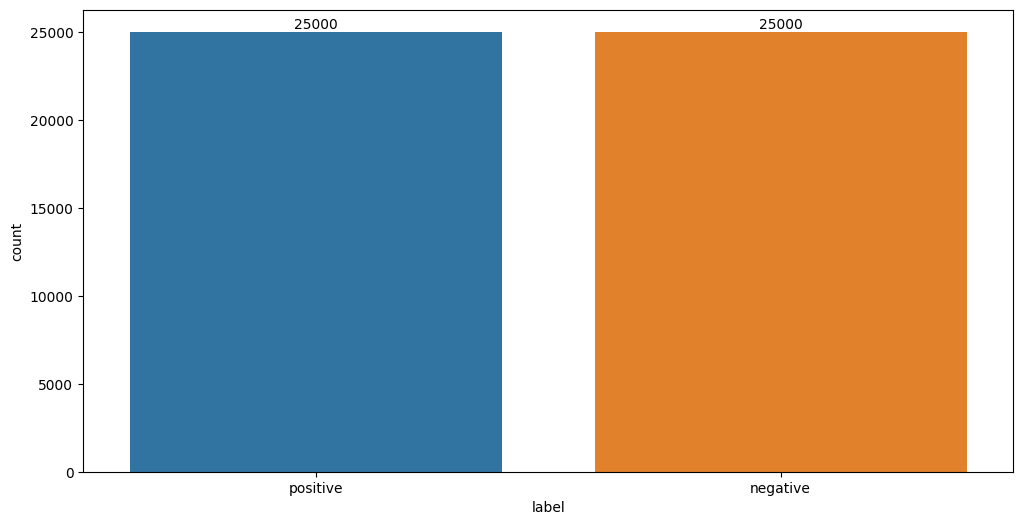

In [5]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=imdb_df)
ax.bar_label(ax.containers[0])

## View Word Counts & Word Count Distribution 

In [6]:
imdb_df['num_word_text'] = imdb_df['text'].apply(lambda x:len(str(x).split()))
imdb_df.head()

,text,label,num_word_text
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


In [7]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
imdb_df.describe()

,num_word_text
count,50000.00000
mean,231.15694
std,171.34400
min,4.00000
25%,126.00000
50%,173.00000
75%,280.00000
max,2470.00000


### Longest Entries
There are a fair number of quite long entries, as to be expected from movie reviews. We'll allow the tokenizer to truncate these accordingly rather than filtering out. If there were only a few outliers, we would remove them.

In [8]:
# check longest entires
pd.options.display.max_colwidth = 200
long_text_df = imdb_df.loc[imdb_df['num_word_text'] > 600]
long_text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2374 entries, 29 to 49981
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           2374 non-null   object
 1   label          2374 non-null   object
 2   num_word_text  2374 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 74.2+ KB


<AxesSubplot: xlabel='num_word_text', ylabel='Count'>

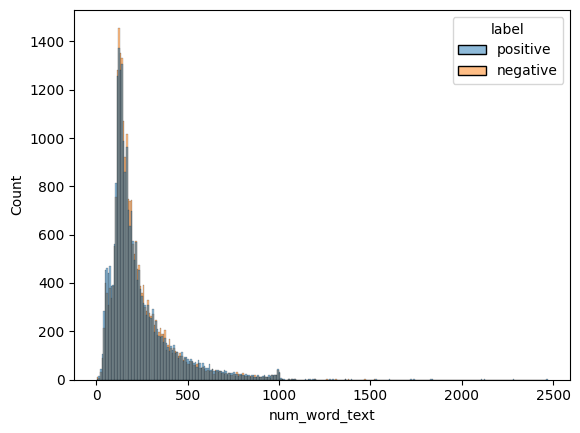

In [9]:
sns.histplot(x="num_word_text", data=imdb_df,  hue="label", palette="tab10")

In [10]:
pd.options.display.max_colwidth = 100
imdb_df['text']

0        One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....
1        A wonderful little production. <br /><br />The filming technique is very unassuming- very old-ti...
2        I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...
3        Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...
4        Petter Mattei's "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei off...
                                                        ...                                                 
49995    I thought this movie did a down right good job. It wasn't as creative or original as the first, ...
49996    Bad plot, bad dialogue, bad acting, idiotic directing, the annoying porn groove soundtrack that ...
49997    I am a Catholic taught in parochial elementary schools by nuns, taught by Jesuit priests in high...
49998    I'm going 

### Shortest Entries

In [11]:
imdb_df.loc[imdb_df['num_word_text'] == 4]

,text,label,num_word_text
28920,Primary plot!Primary direction!Poor interpretation.,negative,4


#### View Tokenized Length
Below, we find that many of the IMDB sequences reach max length.

In [12]:
train_token_id = []

# encode training text
for sample in imdb_df.text.values:
  encoding_dict = preprocessing_dyna(sample, params.tokenizer)
  # parse encoding dict to lists
  train_token_id.append(encoding_dict['input_ids']) 

In [ ]:
train_token_id[:2]

In [14]:
lengths = []
for i in train_token_id:
    lengths.append(len(i))

print(len(lengths))
print(lengths[:10])
print(f'Max Tokenized Sequence Length: {max(lengths)}')

50000
[256, 216, 213, 180, 256, 157, 179, 212, 164, 44]
Max Tokenized Sequence Length: 256


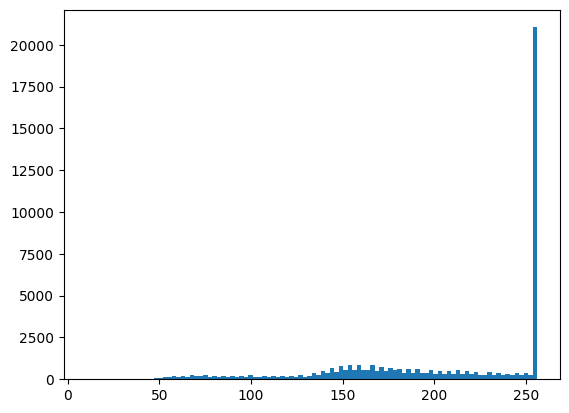

In [15]:
# make a histogram from the lengths
plt.hist(lengths, bins=100)
plt.show()

## Adjust & Export Datasets for Train/Test
We begin by mapping "positive" to 1 and "negative" to 0.

In [16]:
imdb_df['label'] = imdb_df['label'].map({"negative": 0, "positive": 1})
imdb_df.head()

,text,label,num_word_text
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,1,307
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-ti...,1,162
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",1,166
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",1,230


In [17]:
# shuffle dataframe and reset index
imdb_df = imdb_df.sample(frac=1, random_state=1).reset_index(drop=True)

imdb_df.head()

,text,label,num_word_text
0,With No Dead Heroes you get stupid lines like that as this woefully abysmal action flick needs t...,0,308
1,I thought maybe... maybe this could be good. An early appearance by the Re-Animator (Jeffery Com...,0,190
2,An elite American military team which of course happens to include two good looking women and a ...,0,309
3,Ridiculous horror film about a wealthy man (John Carradine) dying and leaving everything to his ...,0,243
4,"Well, if you are one of those Katana's film-nuts (just like me) you sure will appreciate this me...",1,91


In [18]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           50000 non-null  object
 1   label          50000 non-null  int64 
 2   num_word_text  50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


### Test Split

In [19]:
# get 2,500 samples from each class
imdb_test = imdb_df.groupby('label', group_keys=False).apply(lambda x: x.sample(2500, random_state=1))
imdb_test

,text,label,num_word_text
43029,"When I first popped in Happy Birthday to Me, I checked the timer to see how long the film was. I...",0,917
18923,"I wasn't entirely sure what to expect from a Comedy, Drama, Fantasy, Sci-Fi genre, but, given th...",0,204
33831,"After a lively if predictable opening bank-heist scene, 'Set It Off' plummets straight into the ...",0,373
25035,To the small minority seen here praising this film GET SERIOUS. I know it's down to peoples pers...,0,180
16488,"I just caught ""Wild Rebels"" on one of the ""Mystery Science Theatre 3000"" archive compilations, a...",0,264
...,...,...,...
12972,How can a movie be both controversial and gentle? This one does it with a near-perfect structure...,1,120
35798,This is a totally delightful and unexpected film. You start by following a young person who hope...,1,177
38762,"Hi! Being able to speak Cantonese, I found this very funny and was able to all the jokes that on...",1,253
23721,"I don't know if I'd consider it a masterpiece of not, but it's damn near close; it's extremely w...",1,591


In [20]:
# remove test set samples from dataset
imdb_df = imdb_df.drop(imdb_test.index)
imdb_df

,text,label,num_word_text
1,I thought maybe... maybe this could be good. An early appearance by the Re-Animator (Jeffery Com...,0,190
3,Ridiculous horror film about a wealthy man (John Carradine) dying and leaving everything to his ...,0,243
5,"I'm so confused. I've been a huge Seagal fan for 25 years. I've seen all of his films, and many ...",0,217
6,"This movie is not that interesting, except for the first ten minutes. The pace and editing are a...",0,373
7,"This movie starts slow, then tapers off. After watching for about an hour, and seeing absolutely...",0,164
...,...,...,...
49995,"The larger-than-life figures of Wyatt Earp and Bat Masterson, and the specters of George Armstro...",1,393
49996,"Okay, you have:<br /><br />Penelope Keith as Miss Herringbone-Tweed, B.B.E. (Backbone of England...",0,557
49997,"An odd, willfully skewed biopic of Dyan Thomas in which we hear little more than a dozen lines o...",0,188
49998,"Basic structure of a story: Beginning, Middle, End.<br /><br />Sometimes this structure is playe...",0,319


### Validation Split

In [21]:
# get 2,500 samples from each class
imdb_validation = imdb_df.groupby('label', group_keys=False).apply(lambda x: x.sample(2500, random_state=1))
imdb_validation

,text,label,num_word_text
1078,"Much as we all love Al Pacino, it was painful to see him in this movie. A publicity hack at the ...",0,144
15765,"This is one of the worst movies I've seen in a long time. Not just the story, but the acting is ...",0,148
18899,One of two movies I have actually thought about asking for money to stay until the end. Most mov...,0,65
40942,"In the future of 2001, Freddy is after the last surviving teenager of Elm Street. Forsaking ANY ...",0,154
37548,This Santa movie starts off strange and I think Santa might be a pedo. Instead of the usual elf ...,0,638
...,...,...,...
45374,"An unassuming, subtle and lean film, ""The Man in the White Suit"" is yet another breath of fresh ...",1,301
12356,I first saw this film in 1980 in the midday movie spot. After many subsequent viewings (and purc...,1,128
33193,"Surprisingly effective British drama about two very different people who find common ground, and...",1,145
26991,"As far as the Muppet line goes, however, this is not the best, nor the second best. This was mar...",1,130


In [22]:
# remove validation set samples from dataset
imdb_df = imdb_df.drop(imdb_validation.index)
imdb_df


,text,label,num_word_text
3,Ridiculous horror film about a wealthy man (John Carradine) dying and leaving everything to his ...,0,243
5,"I'm so confused. I've been a huge Seagal fan for 25 years. I've seen all of his films, and many ...",0,217
6,"This movie is not that interesting, except for the first ten minutes. The pace and editing are a...",0,373
7,"This movie starts slow, then tapers off. After watching for about an hour, and seeing absolutely...",0,164
8,<br /><br />**********SPOILER ALERT***************<br /><br />If you happen to like JURASSIC PAR...,0,233
...,...,...,...
49995,"The larger-than-life figures of Wyatt Earp and Bat Masterson, and the specters of George Armstro...",1,393
49996,"Okay, you have:<br /><br />Penelope Keith as Miss Herringbone-Tweed, B.B.E. (Backbone of England...",0,557
49997,"An odd, willfully skewed biopic of Dyan Thomas in which we hear little more than a dozen lines o...",0,188
49998,"Basic structure of a story: Beginning, Middle, End.<br /><br />Sometimes this structure is playe...",0,319


### Train Split

[Text(0, 0, '20000'), Text(0, 0, '20000')]

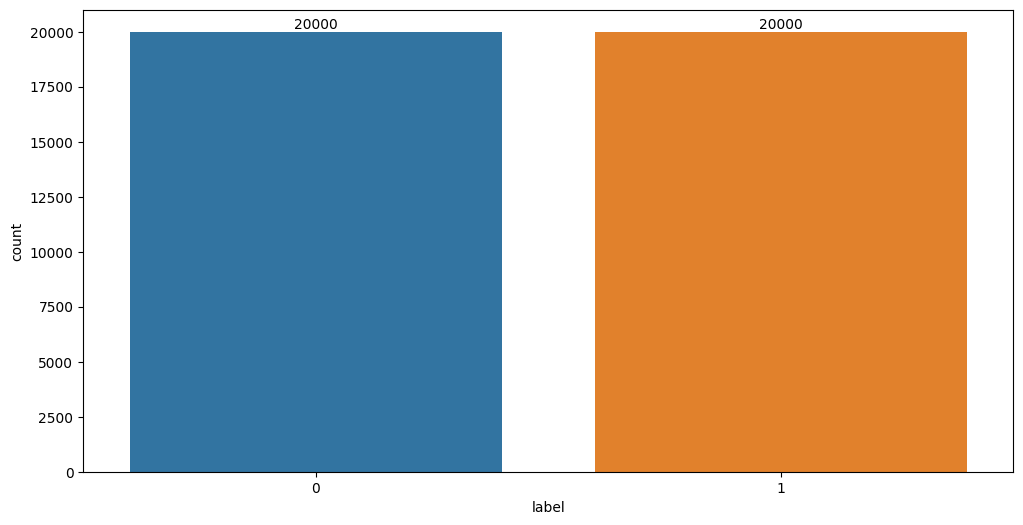

In [23]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=imdb_df)
ax.bar_label(ax.containers[0])

In [24]:
# get 20,000 samples from each class
imdb_train = imdb_df.groupby('label', group_keys=False).apply(lambda x: x.sample(20000, random_state=1))
imdb_train

,text,label,num_word_text
28593,"This film was a Mexican made horror film from the late 60s. It's not that good, but really not s...",0,301
41348,"I had very high hopes walking into this movie. After all, Ocean's 11 was a truly great Hollywood...",0,707
8093,"There really are no redeeming factors about this show. To put it simply, its just terrible. Abso...",0,844
46578,"Jamie Foxx is my favorite comedian. However, I feel that he sold out in order to gain his first ...",0,120
3907,"36/100. This is not to be confused with the decent Arachnophobia, this film is a very low budget...",0,116
...,...,...,...
27611,"After his earlier movie ""Videodrome"", which definitely shows similarities to this movie, directo...",1,492
43213,I have seen this movie many times and i never get sick of it. it is about a man coming out of th...,1,124
13124,This has the funnist jokes out of all the Cheech & Chong flicks. It's the first one I saw with t...,1,115
30684,very rarely it happens that i sit down to write a comment for a movie....but this movie!!!!!!oh ...,1,222


### Double-Check Distribution
Our training set distribution is perfectly balanced while our validation and test sets are representative of the original dataset's distribution.

Text(0.5, 1.0, 'Train Set Label Distribution')

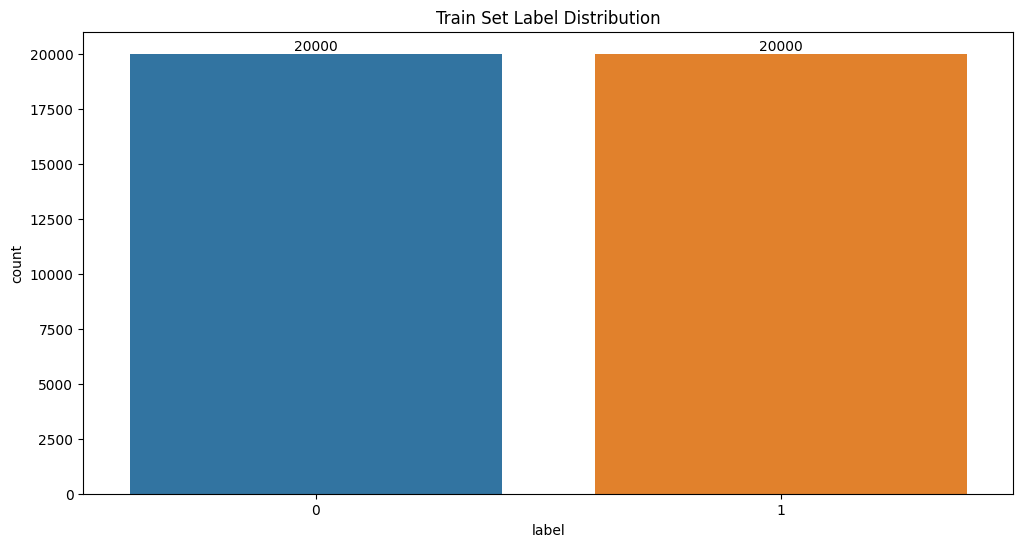

In [25]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=imdb_train)
ax.bar_label(ax.containers[0])
plt.title("Train Set Label Distribution")

Text(0.5, 1.0, 'Validation Set Label Distribution')

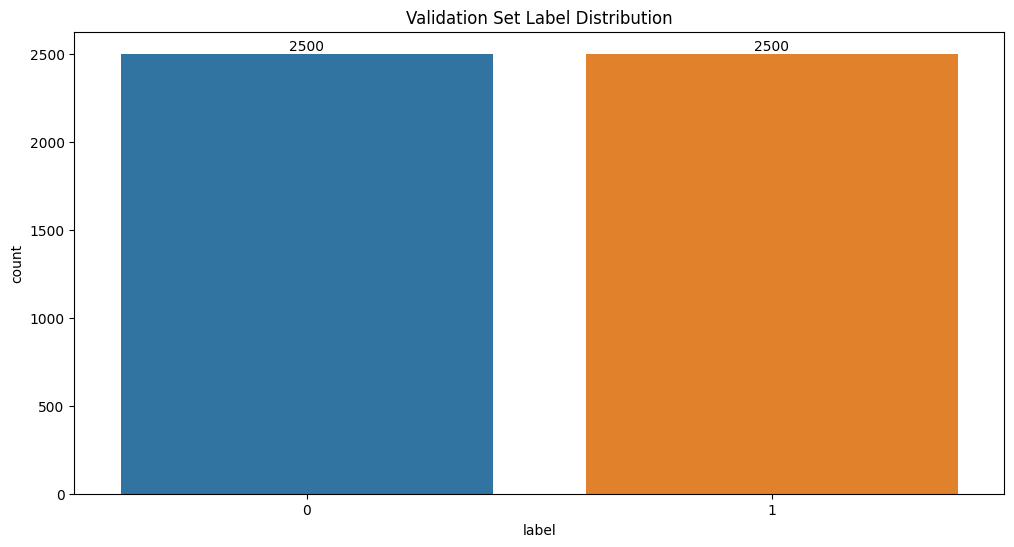

In [26]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=imdb_validation)
ax.bar_label(ax.containers[0])
plt.title("Validation Set Label Distribution")

Text(0.5, 1.0, 'Test Set Label Distribution')

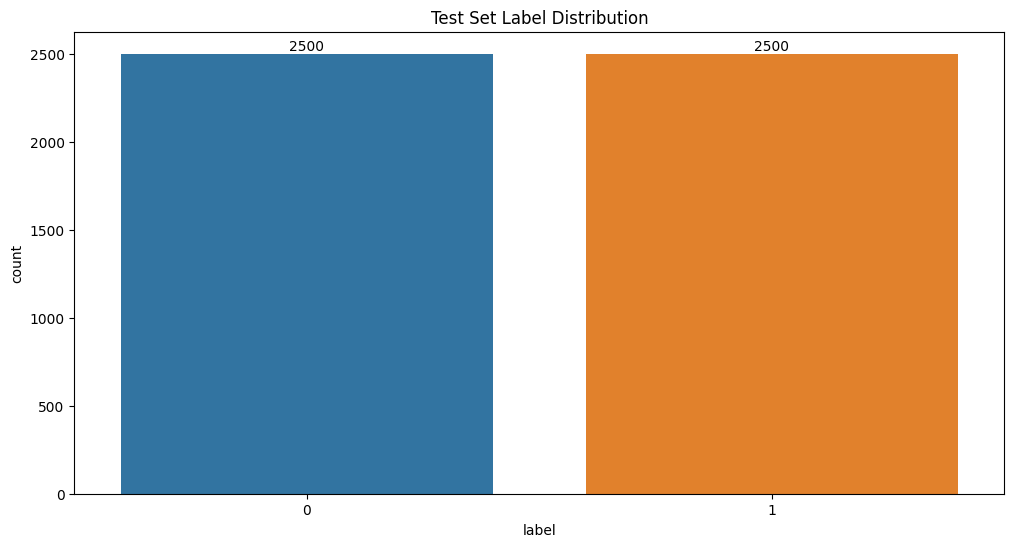

In [27]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=imdb_test)
ax.bar_label(ax.containers[0])
plt.title("Test Set Label Distribution")

## Export Datasets

In [28]:
# reconstitute the updated datafames into a DatasetDict object
train_dataset = Dataset.from_pandas(imdb_train, preserve_index=False)
validate_dataset = Dataset.from_pandas(imdb_validation, preserve_index=False)
test_dataset = Dataset.from_pandas(imdb_test, preserve_index=False)
imdb_datasets = datasets.DatasetDict({"train": train_dataset, 
                                     "validation":validate_dataset, 
                                     "test":test_dataset})

In [29]:
imdb_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'num_word_text'],
        num_rows: 40000
    })
    validation: Dataset({
        features: ['text', 'label', 'num_word_text'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text', 'label', 'num_word_text'],
        num_rows: 5000
    })
})

In [30]:
imdb_datasets.save_to_disk("data/inter_IMDB_sentiment/itesd_imdb_balanced.hf")

Saving the dataset (0/1 shards):   0%|          | 0/40000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]